<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/3.%20Unsupervised/entrega_Salo/src/density_and_distance_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load required libraries

In [75]:
# Install UMAP library
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import umap
import pandas as pd
import seaborn as sns
import plotly.express as px

# UMAP for non-linear dimensionality reduction

The Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction algorithm used for visualizing and clustering high-dimensional data. It works by preserving the local structure of the data while optimizing a low-dimensional representation that is easier to visualize and analyze.

## Example on iris data set

In [77]:
# Load the data
iris = sns.load_dataset('iris')
X = iris.drop('species', axis=1)

In [78]:
def normalize_data(X):
    """ Normalize data to be between 0 and 1.
    Args:
        X (_np.array_): the data to be normalized.
    Returns:
        _np.array_: the normalized data.
    """
    X = X - np.min(X, axis=0)
    X = X / np.max(X, axis=0)
    return X


In [79]:
# Normalize data to the hypercube [0,1]
X = normalize_data(X)
iris.iloc[:,:-1] = X

In [80]:
# Fit the UMAP model and transform the data. Embed the data to a 2D space (n_components)
reducer = umap.UMAP(n_components=2, metric="euclidean", min_dist=0.3, n_neighbors=5)
embedding = reducer.fit_transform(X)

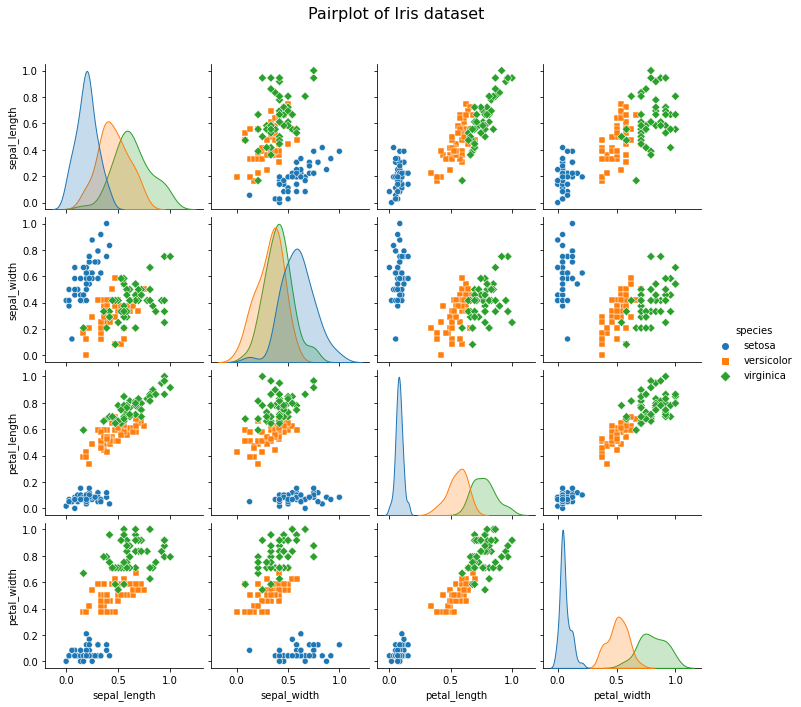

In [81]:
# Plot the original data set
g = sns.pairplot(data=iris, hue='species', markers=["o", "s", "D"]);
g.fig.suptitle("Pairplot of Iris dataset", size=16)
g.figure.subplots_adjust(top=.9)

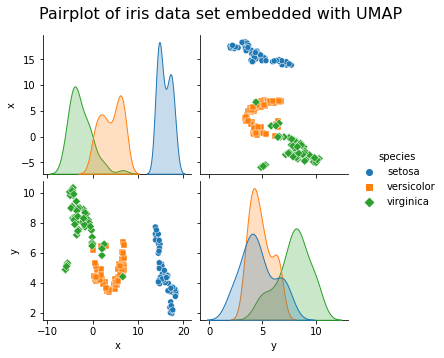

In [82]:
# Plot the reduced data in 2D
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df['species'] = iris['species']
g = sns.pairplot(data=embedding_df, hue='species', markers=["o", "s", "D"])
g.fig.suptitle("Pairplot of iris data set embedded with UMAP", size=16)
g.figure.subplots_adjust(top=.9)

# Clustering algorithms




In this section we focus on the implementation of density-based and distance-based clustering algorithms and provide an example with the iris data set ("toy data") for each algorithm. The algorithms are:


**Density-based**
1. Mountain
2. Substractive
**Distance-based**
3. $k$-means
4. fuzzy $c$-means

### Auxiliary functions



In [83]:
# Plot data in 2D and 3D

def plot_data(X, Y, labels, colors=None, hold_on=False):
    """ Plot the data with colored labels and legend.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
    """
    if not hold_on:
        plt.figure(figsize=(8, 6))
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y = X[Y==i, 0], X[Y==i, 1]
        if colors is None:
            plt.scatter(x, y, label=labels[i])
        else:
            plt.scatter(x, y, label=labels[i], color=next(color))
    plt.legend()
    if not hold_on:
        plt.show()

# Plot the data in 3D
def plot_data_3d(X, Y, labels, colors=None, hold_on=False, ax=None):
    """ Plot the data in 3D.
    Args:
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
        colors (_list_): the colors to be used for the data.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    Raises:
        ValueError: if hold_on is True and ax is None.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif ax is None:
        raise ValueError('If hold_on is True, then ax must be provided')
    else:
        ax = ax
    if colors is not None:
        color = itertools.cycle(colors)
    for i in range(len(labels)):
        x, y, z = X[Y==i, 0], X[Y==i, 1], X[Y==i, 2]
        if colors is None:
            ax.scatter(x, y, z, label=labels[i])
        else:
            ax.scatter(x, y, z, label=labels[i], color=next(color))
    if not hold_on:
        plt.show()

In [84]:
# Create and plot grid space

def create_grid_space(granularity=100, dimensions=2):
    """Create a grid space of points that can be used to color the points in the data set.
    Args:
        granularity (_int_): the number of points in each dimension of the grid space.
        dimensions (_int_): the number of dimensions of the grid space.
    Returns:
        _np.array_: a numpy array containing the grid space points or coordinates.
    """
    grid_space = np.meshgrid(*[np.linspace(0, 1, granularity) for _ in range(dimensions)])
    grid_space = np.array([x.flatten() for x in grid_space]).T
    return grid_space

def plot_grid_space(grid_space, hold_on=False, ax=None):
    """Plot the grid space. If the number of dimensions is 2, then plot the grid space as a scatter plot.
    If the  number of dimensions is 3, then plot the grid space as a 3D scatter plot. If the number of
    dimensions is greater than 3, then plot the grid space as a 2D scatter plot with the first two dimensions.
    If the number of dimensions is 1, then plot the grid space as points.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        hold_on (_bool_): whether to hold on to the current plot or not.
        ax (_matplotlib.axes.Axes_): the axes to plot on.
    """
    if not hold_on:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    elif grid_space.shape[1] >= 3 and ax is None:
        raise ValueError('If hold_on is True for spaces >= 3D, then ax must be provided')
    else:    
        ax = ax
    if (
        grid_space.shape[1] == 2
    ):
        plt.scatter(grid_space[:, 0], grid_space[:, 1], label='grid space')
    elif grid_space.shape[1] >= 3:
        ax.scatter(grid_space[:, 0], grid_space[:, 1], grid_space[:, 2], label='grid space')
    elif grid_space.shape[1] == 1:
        plt.scatter(grid_space[:, 0], np.zeros(grid_space.shape[0]), label='grid space')
    if not hold_on:
        plt.legend()
        plt.show()

def plot_gridAndData(grid_space, with_data=False, X=None, Y=None, labels=None):
    """ Plot the grid space and the data.
    Args:
        grid_space (_np.array_): the grid space to be plotted.
        with_data (_bool_): whether to plot the data or not.
        X (_np.array_): the data to be plotted.
        Y (_np.array_): the labels of the data.
        labels (_list_): the labels of the data.
    """
    fig = plt.figure(figsize=(8, 6))
    if with_data:
        X, Y, labels = X, Y, labels
    if grid_space.shape[1] >= 3 and X.shape[1] >= 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_grid_space(grid_space, hold_on=True, ax=ax)
        if with_data:
            plot_data_3d(X, Y, labels, hold_on=True, ax=ax)
    else:
        ax = fig.add_subplot(111, projection=None)
        plot_grid_space(grid_space, hold_on=True)
        if with_data:
            plot_data(X, Y, labels, hold_on=True)
    plt.legend()
    plt.show()
    

In [85]:
# Functions to visualize results
# Function to gather results in a data frame
def results2df(data, names, Y_hat, C):
    """ Gather results in a data frame. This function concatenates the data with the predicted labels and the
    centers of the clusters. The data frame is then sorted by cluster number.
    
    Args:
        data (pd.DataFrame): the data to be clustered.
        names (list): the list of feature names.
        Y_hat (np.array): the predicted labels.
        C (np.array): the centers of the clusters.
    
    Returns:
        pd.DataFrame: the data frame with the data, the predicted labels, and the centers of the clusters.
    """
    # Concatenate data with predicted labels
    results_df = np.concatenate([data.values, np.expand_dims(Y_hat, axis=1)], axis=1)

    # Convert to data frame
    results_df = pd.DataFrame(results_df, columns=[*names, "cluster"])

    # Convert cluster column to string
    results_df['cluster'] = results_df['cluster'].astype(int)
    results_df['cluster'] = results_df['cluster'].astype(str)

    # Add "cluster" to each cluster number
    results_df['cluster'] = "cluster " + results_df['cluster']

    # Sort by cluster column
    results_df = results_df.sort_values(by=["cluster"])

    # Create temporary center data frame to be merged
    centers_df = pd.DataFrame(C)

    # Define label for centers
    centers_df["cluster"] = "center"

    # Rename columns so both data frames match
    centers_df.columns = results_df.columns

    # Concatenate data frames into a single one
    results_df = pd.concat([results_df, centers_df], axis=0, ignore_index=True)
    
    return results_df

# 2D and 3D scatter plots with plotly
def plotly_scatter(df, names, plot_type="2D", color=None, title=None, color_discrete_sequence=None, opacity=1):
    """ Create a 2D or 3D scatter plot with plotly.
    
    Args:
        df (pd.DataFrame): the data to be plotted.
        names (list): the list of feature names.
        plot_type (str): the type of plot, must be "2D" or "3D".
        color (str): the name of the column to be used as color.
        title (str): the title of the plot.
        color_discrete_sequence (list): the list of colors to be used.
        opacity (float): the opacity of the points.
        
    Returns:
        None
    """
    if color_discrete_sequence == None:
        color_discrete_sequence = [*list(range(len(df.iloc[:,-1].unique())-1)),"black"]
    if plot_type=="2D":
      fig = px.scatter(data_frame=df, x=names[0], y=names[1], color=color,
                         title=title, color_discrete_sequence=color_discrete_sequence)
    elif plot_type=="3D":
      fig = px.scatter_3d(data_frame=df, x=names[0], y=names[1], z=names[2],
                            color=color, title=title, color_discrete_sequence=color_discrete_sequence)
    else:
        raise ValueError("Invalid plot_type muste be ""2D"" or ""3D"".")
    fig.update_traces(opacity=opacity)
    fig.show()

In [86]:
# Transform membership matrix into cluster labels.
def membership_to_labels(membership):
    """ Transform membership matrix into cluster labels.
    
    Args:
        membership (np.array): the membership matrix.
        
    Returns:
        np.array: the resulting cluster labels.
    """
    return np.argmax(membership, axis=1)

## Distance function
We consider 4 distance norms: Manhattan, Euclidean, Mahalanobis and Cosine.

In [87]:
def distance(x, y, dist_type):
    """Distance function.
    
    Args:
        x (np.array): the first point.
        y (np.array): the second point.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
    
    Returns:
        float: the distance between the two n-dimensional points or vectors.
    """
    if dist_type == 1:
        return np.sum(np.abs(x - y))
    elif dist_type == 2:
        return np.sqrt(np.sum((x - y) ** 2))
    elif dist_type == "mahal":
        return np.sqrt((x-y).T @ np.linalg.inv(np.cov(x)) @ (x-y))
    elif dist_type == "cos":
        return 1 - np.dot(x, y) / (np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2)))
    else:
        raise ValueError("Invalid distance type.")

## Mountain

In [88]:
def mountain_clustering(X, granularity, sigma, beta=None, dist_type=2):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        granularity (_int_): the granularity of the grid space, i.e., the number of points in each dimension.
        K (_int_): the number of clusters.
        sigma (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        beta (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*sigma.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if beta is None:
        beta = 2*sigma

    num_obs, num_features = X.shape
    num_grid_points = granularity**num_features
    
    # Assume a big fixed number of clusters
    K = 100

    # Create grid space (array where each row is a point in the grid space or a tuple of coordinates)
    grid_space = create_grid_space(granularity=granularity, dimensions=num_features)
    # Initialize mountain matrix and mountain centers
    M = np.zeros(num_grid_points)
    M_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the mountain matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        print(f'Calculating cluster center {cluster}...')
        for i, point in enumerate(grid_space):
            for j in range(num_obs):
                if cluster == 0:
                    M[i] += np.exp(-distance(point, X[j,:], dist_type)**2 / (2*sigma**2))
                else:
                    M[i] = M[i] - M[C_idx[cluster-1]]*np.exp(-distance(point, C[cluster-1], dist_type)**2 / (2*beta**2))
        
        # Get index of maximum value in mountain matrix
        C_idx[cluster] = int(np.argmax(M))
        # Set current cluster as the maximum value in mountain matrix
        new_center = grid_space[C_idx[cluster], :]
        
        # Stop criteria Check if the new center is already in the list of centers or if the mountain value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            M[C_idx[cluster]] < min(1e-3, 0.5/(granularity-1))
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            M_centers = M_centers[:cluster]
            print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and mountain centers
        C[cluster, :] = new_center
        M_centers[cluster] = M[C_idx[cluster]]
        
        # Print the current cluster center and mountain center value
        print(f'Cluster center {cluster} : {C[cluster]}')
        print(f'Mountain center value {M_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, M

### Example on iris data set

In [89]:
# Randomly split data into train and test with split_ratio = train ratio, and test_ratio = 1 - split_ratio
def splitData(X, split_ratio=0.8, random_seed=0):
    """ Split the data into training and testing sets.

    Args:
        df (np.array): the data to be split.
        split_ratio (float): the ratio of the training set to the whole dataset.
        random_seed (int): the random seed.
    
    Returns:
        pd.DataFrame: the training set.
        pd.DataFrame: the testing set.
    """
    df = pd.DataFrame(X)
    train=df.sample(frac=0.8,random_state=random_seed)
    test=df.drop(train.index)
    return train.values, test.values


In [90]:
# Reload the data
iris = load_iris()
X, Y, labels, names = iris.data, iris.target, iris.target_names, iris.feature_names

# Normalize data to the hypercube [0,1]
X = normalize_data(X)

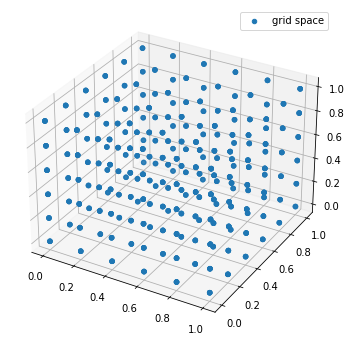

In [91]:
# Visualize an example grid space
grid_space = create_grid_space(granularity=6, dimensions=X.shape[1])
plot_grid_space(grid_space)

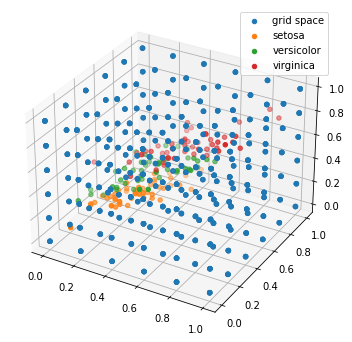

In [92]:
# Visualize grid space and original data
plot_gridAndData(grid_space, with_data=True, X=X, Y=Y, labels=labels)

In [93]:
# Run mountain clustering with train data
C_m, Y_hat_m, M_m = mountain_clustering(X, granularity=2, sigma=0.2, dist_type=2)

Calculating cluster center 0...
Cluster center 0 : [0. 1. 0. 0.]
Mountain center value 3.8438099103680727
Calculating cluster center 1...
Cluster center 1 : [1. 0. 1. 1.]
Mountain center value 1.034676050394805
Calculating cluster center 2...
Cluster center 2 : [1. 1. 1. 1.]
Mountain center value 0.8288423341872719
Calculating cluster center 3...
Number of clusters found: 3 
 with points [[0. 1. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]]


In [94]:
# Gather results in a data frame
results_m = results2df(pd.DataFrame(X, columns=names), names, Y_hat_m, C_m)

In [95]:
# Visualize results in 2D
plotly_scatter(results_m, names, plot_type="2D", color=results_m.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

In [96]:
# Visualize results in 3D
plotly_scatter(results_m, names, plot_type="3D", color=results_m.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

## Substractive

In [97]:
def substractive_clustering(X, ra, rb=None, dist_type=2, tol = 1e-3):
    """A clustering algorithm that uses a mountain matrix to cluster data.

    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        K (_int_): the number of clusters.
        ra (_float_): the height and the smoothing of the mountain function. Is an application specific parameter, that
        acts as the kernel influence or bandwidth for the mountain function construction and update.
        rb (_float_, optional): the height and the smoothing of the updated mountain function. Defaults to None, as it
        is internally defined as 2*ra.
        dist_type (_int_, optional): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine. Defaults to 2.
        tol (_float_, optional): the tolerance for the stopping criterion. Defaults to 1e-3.

    Returns:
        _tuple_: a tuple containing the cluster centers, the resulting cluster labels and the mountain matrix.
    """
    if rb is None:
        rb = 2*ra

    num_obs, num_features = X.shape
    
    # Assume a big fixed number of clusters
    K = 100

    # Initialize density matrix and density centers
    density= np.zeros(num_obs)
    density_centers = np.zeros(K)
    # Initialize cluster centers
    C = np.zeros(shape=(K, num_features))
    C_idx = np.zeros(K).astype(int)

    # Calculate the density matrix for the remaining cluster centers (except the first one)
    cluster = 0
    while True:
        print(f'Calculating cluster center {cluster}...')
        for i in range(num_obs):
            for j in range(num_obs):
                if cluster == 0:
                    density[i] += np.exp(-distance(X[i,:], X[j,:], dist_type) / (ra/2)**2)
                else:
                    density[i] -= density_centers[cluster-1]*np.exp(-distance(X[i,:], C[cluster-1], dist_type) / (rb/2)**2)
        
        # Get index of maximum value in density matrix
        C_idx[cluster] = int(np.argmax(density))
        # Set current cluster as the maximum value in density matrix
        new_center = X[C_idx[cluster], :]
        new_density = density[C_idx[cluster]]
        # Stop criteria Check if the new center is already in the list of centers or if the density value is too small.
        if ( np.any(np.equal(C, new_center).all(axis=1)) ) or (
            abs(new_density) < tol) or (abs(new_density / density_centers[cluster-1]) < 1e-1
        ):
            C = C[:cluster, :]
            C_idx = C_idx[:cluster]
            density_centers = density_centers[:cluster]
            print(f'Number of clusters found: {cluster} \n with points {C}')
            break
        
        # Update the cluster centers and density centers
        C[cluster, :] = new_center
        density_centers[cluster] = density[C_idx[cluster]]
        
        # Print the current cluster center and density center value
        print(f'Cluster center {cluster} : {C[cluster]}')
        print(f'Density center value {density_centers[cluster]}')
        
        # Advance to the next cluster
        cluster += 1

    # Calculate which points are within each cluster
    Y_hat = np.zeros(num_obs)
    Y_hat = np.argmin(np.linalg.norm(X[:, np.newaxis, :] - C[np.newaxis, :, :], axis=2), axis=1)
    return C, Y_hat, density

### Example on iris data set

In [98]:
# Run substractive clustering
C_s, Y_hat_s, density_s = substractive_clustering(X, ra=0.4, dist_type = 2, tol = 1e-3)

Calculating cluster center 0...


<ipython-input-97-657381523901>:51: RuntimeWarning:

divide by zero encountered in double_scalars



Cluster center 0 : [0.22222222 0.58333333 0.08474576 0.04166667]
Density center value 4.368703878901702
Calculating cluster center 1...
Cluster center 1 : [0.72222222 0.5        0.79661017 0.91666667]
Density center value 1.6621981911324384
Calculating cluster center 2...
Cluster center 2 : [0.16666667 0.20833333 0.59322034 0.66666667]
Density center value -4.520939495376534
Calculating cluster center 3...
Number of clusters found: 3 
 with points [[0.22222222 0.58333333 0.08474576 0.04166667]
 [0.72222222 0.5        0.79661017 0.91666667]
 [0.16666667 0.20833333 0.59322034 0.66666667]]


In [99]:
# Gather results in a data frame
results_s = results2df(pd.DataFrame(X, columns=names), names, Y_hat_s, C_s)

In [100]:
# Visualize results in 2D
plotly_scatter(results_s, names, plot_type="2D", color=results_s.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

In [101]:
# Visualize results in 3D
plotly_scatter(results_s, names, plot_type="3D", color=results_s.columns[-1],
               title="Centers obtained from density-based clustering for train data", opacity=0.7)

## $k$-means

In [102]:
def kmeans(x, k, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None):
    """ K-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        init (list): the initial centers.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
    
    if init is None:
        init = []
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)

        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the centers.
        for i in range(k):
            centers[i, :] = np.mean(x[membership[:, i] == 1, :], axis=0)

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [103]:
# Run k-means
C_k, membership_k, costs_k = kmeans(X, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=True, init=None)

Iteration: 1, Cost: 37.7509735908856
Iteration: 2, Cost: 35.19644408211808
Iteration: 3, Cost: 35.07034805636518
Iteration: 4, Cost: 35.30738399205112
Iteration: 5, Cost: 35.34088326794366
Iteration: 6, Cost: 35.380495080209634
Iteration: 7, Cost: 35.43982480420535
Iteration: 8, Cost: 35.44707747754874


In [104]:
# Transform membership matrix into cluster labels
Y_hat_k = membership_to_labels(membership_k)

In [105]:
# Gather results in a data frame
results_k = results2df(pd.DataFrame(X, columns=names), names, Y_hat_k, C_k)

In [106]:
# Visualize results in 2D
plotly_scatter(results_k, names, plot_type="2D", color=results_k.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [107]:
# Visualize results in 3D
plotly_scatter(results_k, names, plot_type="3D", color=results_k.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

## fuzzy $c$-means

In [108]:
def fuzzyCmeans(x, k, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=False):
    """ Fuzzy C-means algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        m (float): the fuzziness parameter.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        
    Returns:
        np.array: the cluster centers.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
       
    n_obs, n_features = x.shape
    # Initialization the membership matrix.
    membership = np.random.rand(n_obs, k)
    membership = membership / np.sum(membership, axis=1, keepdims=True)

    iteration = 0
    centers = np.zeros((k, n_features))
    costs = np.zeros(max_iter+1)
    while True:
        # Calculate the centers.
        for i in range(k):
            centers[i, :] = membership[:, i] * m @ x / np.sum(membership[:, i] * m)

        # Compute the cost function.
        cost = 0
        for i in range(k):
            for j in range(n_obs):
                cost = cost + membership[j, i] ** m * distance(centers[i,:], x[j,:], dist_type)
        costs[iteration] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the membership matrix.
        for i in range(k):
            for j in range(n_obs):
                den = 0
                for l in range(k):
                    den = den + (distance(x[j,:], centers[i,:], dist_type) / distance(x[j,:], centers[l,:], dist_type)) ** (2/(m-1))
                membership[j, i] = 1 / den

        iteration = iteration + 1

        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [109]:
# Run fuzzy c-means
C_c, membership_c, costs_c = fuzzyCmeans(X, k=3, m=2, max_iter=100, tol=1e-3, dist_type=2, verbose=True)

Iteration: 1, Cost: 31.177422822709215
Iteration: 2, Cost: 24.22709620261972
Iteration: 3, Cost: 24.196706384935577
Iteration: 4, Cost: 24.159382117550138
Iteration: 5, Cost: 24.100253078591788
Iteration: 6, Cost: 24.01633945426962
Iteration: 7, Cost: 23.930698487822895
Iteration: 8, Cost: 23.900934232969497
Iteration: 9, Cost: 23.956744945489575
Iteration: 10, Cost: 24.055646414191184
Iteration: 11, Cost: 24.13213531183175
Iteration: 12, Cost: 24.097829697378103
Iteration: 13, Cost: 23.82021864329121
Iteration: 14, Cost: 23.11327012922748
Iteration: 15, Cost: 22.01977489379542
Iteration: 16, Cost: 21.313386959683886
Iteration: 17, Cost: 21.111053733132945
Iteration: 18, Cost: 21.04561719961865
Iteration: 19, Cost: 21.019047364870673
Iteration: 20, Cost: 21.001745419381972
Iteration: 21, Cost: 20.98825826101477
Iteration: 22, Cost: 20.977900390304058
Iteration: 23, Cost: 20.97011326468731
Iteration: 24, Cost: 20.964290777952797
Iteration: 25, Cost: 20.959924034352525
Iteration: 26, Cos

In [110]:
# Transform membership matrix into cluster labels
Y_hat_c = membership_to_labels(membership_c)

In [111]:
# Gather results in a data frame
results_c = results2df(pd.DataFrame(X, columns=names), names, Y_hat_c, C_c)

In [112]:
# Visualize results in 2D
plotly_scatter(results_c, names, plot_type="2D", color=results_c.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [113]:
# Visualize results in 3D
plotly_scatter(results_c, names, plot_type="3D", color=results_c.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

## $k$-medoids

In [114]:
# k-medoids clustering algorithm. Output centers, membership and cost function.
def kmedoids(x, k, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None):
    """ K-medoids algorithm.
    
    Args:
        x (np.array): the features of data to be clustered, usually structured as tidy data.
        k (int): the number of clusters.
        max_iter (int): the maximum number of iterations.
        tol (float): the tolerance for the stopping criterion.
        dist_type (str or float or int): the type of distance to be used. 1: Manhattan, 2: Euclidean,
        "mahal": Mahalanobis and "cos": Cosine.
        verbose (bool): whether to print the cost function at each iteration.
        init (list): the initial centers.
        
    Returns:
        np.array: the cluster centers.
        np.array: the resulting cluster labels.
        np.array: the membership matrix.
        np.array: the cost function at each iteration.
    """
    
    if init is None:
        init = []
    n_obs = x.shape[0]
    # Initialization of the centers.
    if init == [] or len(init) != k:
        init = np.random.choice(n_obs, k, replace=False)
    centers = x[init, :]
    costs = np.zeros(max_iter+1)
    iteration = 0
    while True:
        # Determine of membership of each observation to each cluster.
        membership = np.zeros((n_obs, n_obs), dtype=np.int32)
        for j in range(n_obs):
            min_dist = np.inf
            min_idx = 0
            for i, center in enumerate(centers):
                dist = distance(x[j,:], center, dist_type)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = i
            membership[j, min_idx] = 1

        # Compute the cost function.
        cost = 0
        for j in range(n_obs):
            for i in range(k):
                if membership[j, i] == 1:
                    cost = cost + distance(x[j,:], centers[i,:], dist_type)

        costs[iteration-1] = cost
        # Stop criteria Check if the cost function is too small.
        if iteration > 1 and (
            abs(cost - costs[iteration - 2]) < tol or iteration > max_iter
        ):
            break
        # Update the centers
        for i in range(k):
            min_cost = np.inf
            for j in range(n_obs):
                if membership[j, i] == 1:
                    cost = 0
                    for l in range(n_obs):
                        if membership[l, i] == 1:
                            cost = cost + distance(x[j,:], x[l,:], dist_type)
                    if cost < min_cost:
                        min_cost = cost
                        centers[i,:] = x[j,:]
        iteration = iteration + 1
        if verbose:
            print(f'Iteration: {iteration}, Cost: {cost}')

    return centers, membership, costs

### Example on iris data set

In [115]:
# Run k-medoids
C_km, membership_km, costs_km = kmedoids(X, k=3, max_iter=100, tol=1e-3, dist_type=2, verbose=True, init=None)

Iteration: 1, Cost: 53.817091177047764
Iteration: 2, Cost: 8.538526951300794
Iteration: 3, Cost: 8.538526951300794
Iteration: 4, Cost: 8.538526951300794


In [116]:
# Transform membership matrix into cluster labels
Y_hat_km = membership_to_labels(membership_km)

In [117]:
# Gather results in a data frame
results_km = results2df(pd.DataFrame(X, columns=names), names, Y_hat_km, C_km)

In [118]:
# Visualize results in 2D
plotly_scatter(results_km, names, plot_type="2D", color=results_km.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

In [119]:
# Visualize results in 3D
plotly_scatter(results_km, names, plot_type="3D", color=results_km.columns[-1],
               title="Centers obtained from distance-based clustering for train data", opacity=0.7)

# Clustering validation indexes

Clustering validation indexes are used to evaluate the quality and performance of clustering algorithms. They measure how well the clustering algorithm has grouped similar objects together and separated dissimilar objects. There are two types:


1. **Internal validation indexes:** they are used to evaluate the quality and performance of clustering algorithms based on the data alone, without considering any external information or ground truth. For example: `davies_bouldin_index`, `dunn_index` and `calinski_harabasz_index`.


2. **External validation indexes:** they are used to evaluate the quality and performance of clustering algorithms by comparing the clustering results to external information or ground truth, such as class labels or a labeled dataset. For example: `rand_index`, `jaccard_index` and `fowlkes_mallows_index`.



## Internal validation indexes

In [120]:
# Internal validation indices ----------------------------------------------------

# Davies-Bouldin index
def davies_bouldin_index(X, Y_hat, C):
    """ Davies-Bouldin index. This index is a measure of how well a clustering algorithm
    separates the clusters. The lower the index, the better the clustering. The idea behind this index
    is to measure the distance between clusters and the distance between points within each cluster. It does so
    by calculating the average distance between each cluster and its points and the distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the Davies-Bouldin index.
    DB = 0
    for i in range(k):
        max_dist = 0
        for j in range(k):
            if i != j:
                max_dist = max(max_dist, (avg_dist[i] + avg_dist[j]) / dist[i, j])
        DB = DB + max_dist
    DB = DB / k
    return DB

# Dunn index
def dunn_index(X, Y, C):
    """ Dunn index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance
    between clusters and the distance between points within each cluster. It does so by calculating the minimum
    distance between each cluster and its points and the maximum distance between each pair of clusters.
    This index is a measure of cohesion and separation, which means that it is a measure of how well the clusters are
    separated and how well the points are clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Dunn index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the minimum distance between each cluster and its points.
    min_dist = np.zeros(k)
    for i in range(k):
        min_dist[i] = np.min(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the Dunn index.
    return np.min(min_dist) / np.max(dist)

# Calinski-Harabasz index
def calinski_harabasz_index(X, Y, C):
    """ Calinski-Harabasz index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the distance between
    clusters and the distance between points within each cluster. It does so by calculating the average distance between
    each cluster and its points and the distance between each pair of clusters. This index is a measure of cohesion and
    separation, which means that it is a measure of how well the clusters are separated and how well the points are
    clustered within each cluster.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Calinski-Harabasz index.
    """
    n_obs, n_features = X.shape
    k = len(np.unique(Y))
    # Calculate the distance between each pair of clusters.
    dist = np.zeros((k, k))
    for i, j in itertools.product(range(k), range(k)):
        if i != j:
            dist[i, j] = distance(C[i,:], C[j,:], 2)
    # Calculate the average distance between each cluster and its points.
    avg_dist = np.zeros(k)
    for i in range(k):
        avg_dist[i] = np.mean(distance(X[Y == i, :], C[i,:], 2))
    # Calculate the total average distance between all points and the global center.
    avg_dist_all = np.mean(distance(X, np.mean(X, axis=0), 2))
    # Calculate the Calinski-Harabasz index.
    return (np.sum((k * avg_dist - avg_dist_all) ** 2)) / (k * np.sum(dist))

# Create a function to calculate the internal validation indices
def internal_validation_indices(X, Y, C):
    """ Calculate the internal validation indices. This function computes the Davies-Bouldin index,
    the Dunn index, and the Calinski-Harabasz index. Davies-Bouldin: lower is better, Dunn: higher is better,
    Calinski-Harabasz: higher is better.
    
    Args:
        X (np.array): the features of data to be clustered, usually structured as tidy data.
        Y (np.array): the cluster labels.
        C (np.array): the cluster centers.
        
    Returns:
        float: the Davies-Bouldin index.
        float: the Dunn index.
        float: the Calinski-Harabasz index.
    """
    DB = davies_bouldin_index(X, Y, C)
    DI = dunn_index(X, Y, C)
    CH = calinski_harabasz_index(X, Y, C)
    print(f"Davies-Bouldin index: {DB:.3f}, Dunn index: {DI:.3f}, Calinski-Harabasz index: {CH:.3f}")
    return DB, DI, CH

## External validation indexes

In [121]:
# External validation indices ---------------------------------------------------

# Rand index
def rand_index(Y, Y_hat):
    """ Rand index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return (a + b) / (a + b + c + d)

# Jaccard index
def jaccard_index(Y, Y_hat):
    """ Jaccard index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Jaccard index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        else:
            c = c + 1
    return a / (a + b + c)

# Fowlkes-Mallows index
def fowlkes_mallows_index(Y, Y_hat):
    """ Fowlkes-Mallows index. This index is a measure of how well a clustering algorithm separates the clusters.
    The higher the index, the better the clustering. The idea behind this index is to measure the number of
    pairs of points that are correctly and incorrectly clustered. This index is a measure of the similarity
    between the true labels and the predicted labels.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Fowlkes-Mallows index.
    """
    n_obs = len(Y)
    a = 0
    b = 0
    c = 0
    d = 0
    for i, j in itertools.product(range(n_obs), range(n_obs)):
        if Y[i] == Y[j] and Y_hat[i] == Y_hat[j]:
            a = a + 1
        elif Y[i] != Y[j] and Y_hat[i] != Y_hat[j]:
            b = b + 1
        elif Y[i] == Y[j]:
            c = c + 1
        else:
            d = d + 1
    return np.sqrt(a / (a + c)) * np.sqrt(a / (a + d))

# Create a function to calculate the external validation indices
def external_validation_indices(Y, Y_hat):
    """ Calculate the external validation indices. This function computes the Rand index, the Jaccard index,
    and the Fowlkes-Mallows index. Rand: higher is better, Jaccard: higher is better, Fowlkes-Mallows: higher is better.
    
    Args:
        Y (np.array): the true labels.
        Y_hat (np.array): the predicted labels.
        
    Returns:
        float: the Rand index.
        float: the Jaccard index.
        float: the Fowlkes-Mallows index.
    """
    RI = rand_index(Y, Y_hat)
    JI = jaccard_index(Y, Y_hat)
    FMI = fowlkes_mallows_index(Y, Y_hat)
    print(f"Rand index: {RI:.3f}, Jaccard index: {JI:.3f}, Fowlkes-Mallows index: {FMI:.3f}")
    return RI, JI, FMI

## Example on iris data set

### Indexes for mountain

In [122]:
# Run internal and external validation indices using the results from mountain
DB_m, DI_m, CH_m = internal_validation_indices(X, Y, C_m)
RI_m, JI_m, FMI_m = external_validation_indices(Y, Y_hat_m)

Davies-Bouldin index: 10.011, Dunn index: 1.764, Calinski-Harabasz index: 11.111
Rand index: 0.740, Jaccard index: 0.261, Fowlkes-Mallows index: 0.675


### Indexes for substractive

In [123]:
# Run internal and external validation indices using the results from substractive
DB_s, DI_s, CH_s = internal_validation_indices(X, Y, C_s)
RI_s, JI_s, FMI_s = external_validation_indices(Y, Y_hat_s)

Davies-Bouldin index: 10.365, Dunn index: 1.112, Calinski-Harabasz index: 5.484
Rand index: 0.853, Jaccard index: 0.261, Fowlkes-Mallows index: 0.780


### Indexes for $k$-means

In [124]:
# Run internal and external validation indices using the results from k-means
DB_k, DI_k, CH_k = internal_validation_indices(X, Y, C_k)
RI_k, JI_k, FMI_k = external_validation_indices(Y, Y_hat_k)

Davies-Bouldin index: 22.530, Dunn index: 1.599, Calinski-Harabasz index: 22.750
Rand index: 0.723, Jaccard index: 0.267, Fowlkes-Mallows index: 0.669


### Indexes for fuzzy $c$-means

In [125]:
# Run internal and external validation indices using the results from fuzzy c-means
DB_c, DI_c, CH_c = internal_validation_indices(X, Y, C_c)
RI_c, JI_c, FMI_c = external_validation_indices(Y, Y_hat_c)

Davies-Bouldin index: 37.223, Dunn index: 3.413, Calinski-Harabasz index: 27.542
Rand index: 0.913, Jaccard index: 0.290, Fowlkes-Mallows index: 0.870


### Indexes for $k$-mdoids

In [126]:
# Run internal and external validation indices using the results from k-medoids
DB_km, DI_km, CH_km = internal_validation_indices(X, Y, C_km)
RI_km, JI_km, FMI_km = external_validation_indices(Y, Y_hat_km)

Davies-Bouldin index: 19.214, Dunn index: 1.604, Calinski-Harabasz index: 45.162
Rand index: 0.887, Jaccard index: 0.280, Fowlkes-Mallows index: 0.832


# Experiment on real data

To experiment on real data we will use unlabeled data. This means that the use of density-based clustering will serve as an exploratory approach to decide the optimal number of clusters $k$. Afterwards, we will use distance-based clustering to cluster the data given the amount of optimal clusters $k$. 

We will run every density-based and distance-based clustering methods on 3 rounds with: the original data, the UMAP embedded data in a low-dimensional space, and the hig-dimensional data space resulting from the autoencoder.

## Auxiliary functions

In [127]:
# Function to clean raw data
def clean_data(df, features2drop):
    """ Clean the data. This function removes categorical features, removes NA values, and normalizes the data.
    
    Args:
        df (pd.DataFrame): the data to be cleaned.
        features2drop (list): the list of categorical features to be removed.
        seed (int): the random seed.
        
    Returns:
        pd.DataFrame: the cleaned data.
        list: the list of feature names.
    """

    new_df = df.copy()
    # Remove categorical features
    new_df.drop(features2drop, axis=1, inplace=True)

    # Remove NA values if there are any
    if new_df.isnull().values.sum() > 0:
        new_df.dropna(axis=0, inplace=True)

    # Normalize the data to the hypercube [0,1]
    new_df = normalize_data(new_df)

    # Extract feature names
    names = new_df.columns

    return new_df, names


## Load the data
We use the Mall Customer Segmentation Data ([link to source](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)) which was created for the learning purpose of the customer segmentation concepts, also known as market basket analysis. It contains some basic data about customers like Customer ID, age, gender, annual income and spending score.
Spending Score is a measure assigned to the customer based on predefined parameters like customer behavior and purchasing data.

The data contains 200 customers (rows or observations) with 4 customer features. Because the first feature is categorical (Gender) we remove it. This leaves us with 3 features and, therefore, a 3D space.

In [128]:
# Load and read data set
url = "https://github.com/scardenol/ai_2023/blob/e109f1cc834fa52bcccf49cda29463c9160d164d/3.%20Unsupervised/entrega_Salo/data/Mall_Customers.xls?raw=true"
raw_data = pd.read_csv(url, index_col=0)

In [129]:
# View shape of data
raw_data.shape

(200, 4)

In [130]:
# Visualize data set
raw_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Preprocess

In [131]:
# Remove categorical features, remove NA values, and normalize the data
data, names = clean_data(raw_data, features2drop=['Gender'])

# Set random seed
seed = 0
np.random.seed(seed)

## Visualize

In [132]:
plotly_scatter(data, names, plot_type="3D", title="Original data", opacity=0.7)

## Find the optimal number of clusters $k$

In [133]:
# Run mountain clustering
C_m, Y_hat_m, M_m = mountain_clustering(data.values, granularity=2, sigma=0.2, dist_type=2)

# Get the number of clusters k
k_m = len(C_m)

Calculating cluster center 0...
Cluster center 0 : [0. 0. 1.]
Mountain center value 9.157608302339137
Calculating cluster center 1...
Cluster center 1 : [1. 0. 0.]
Mountain center value 3.702724375097104
Calculating cluster center 2...
Cluster center 2 : [0. 1. 1.]
Mountain center value 1.8012283369396143
Calculating cluster center 3...
Cluster center 3 : [1. 1. 0.]
Mountain center value 0.37905654568462305
Calculating cluster center 4...
Cluster center 4 : [1. 1. 1.]
Mountain center value 0.018895609281122126
Calculating cluster center 5...
Number of clusters found: 5 
 with points [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]


In [134]:
# Run substractive clustering
C_sub, Y_hat_sub, density_sub = substractive_clustering(data.values, ra=0.3, dist_type=2)

# Get the number of clusters k
k_sub = len(C_sub)

Calculating cluster center 0...


<ipython-input-97-657381523901>:51: RuntimeWarning:

divide by zero encountered in double_scalars



Cluster center 0 : [0.57692308 0.36885246 0.48979592]
Density center value 1.9541358007418073
Calculating cluster center 1...
Cluster center 1 : [0.09615385 0.00819672 0.7755102 ]
Density center value 1.5616280686057695
Calculating cluster center 2...
Cluster center 2 : [0.03846154 0.47540984 0.04081633]
Density center value 0.9710937301445737
Calculating cluster center 3...
Cluster center 3 : [0.23076923 1.         0.83673469]
Density center value 0.940082221760337
Calculating cluster center 4...
Cluster center 4 : [0.88461538 0.03278689 0.02040816]
Density center value 0.7304024328622027
Calculating cluster center 5...
Cluster center 5 : [0.26923077 1.         0.17346939]
Density center value 0.5252368649032455
Calculating cluster center 6...
Cluster center 6 : [0.03846154 0.00819672 0.05102041]
Density center value -0.2552657010253564
Calculating cluster center 7...
Number of clusters found: 7 
 with points [[0.57692308 0.36885246 0.48979592]
 [0.09615385 0.00819672 0.7755102 ]
 [0.

## Cluster the data

In [135]:
# Run k-means
C_k, membership_k, costs_k = kmeans(data.values, k=k_m, max_iter=100, tol=1e-3, dist_type=2, verbose=False, init=None)

In [136]:
# Transform membership matrix into cluster labels
Y_hat_k = membership_to_labels(membership_k)

In [137]:
# Gather results and convert to data frame
results_df = results2df(data, names=data.columns, Y_hat=Y_hat_k, C=C_k)

In [138]:
# Plot results
plotly_scatter(results_df, names, plot_type="3D", color="cluster", title="Resulting clusters", opacity=0.7)

# Experiment on embedded data with UMAP

In [139]:
# Perform UMAP on the original data

# Fit the UMAP model and transform the data. Embed the data to a 2D space (n_components)
reducer = umap.UMAP(n_components=2, metric="euclidean", min_dist=0.3, n_neighbors=5)
embedded_data = reducer.fit_transform(data)

# Save the resulting 2D space as a data frame
embedded_data = pd.DataFrame(embedding, columns=["x", "y"])

In [140]:
# Plot the reduced data in 2D
fig = px.scatter(data_frame=embedded_data, x="x", y="y", title="Embedded data with UMAP")
fig.show()